## Gradient Boostingモデルが重視する特徴量を可視化する

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters found: {'subsample': 0.6, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.1}
Best cross-validation AUC: 0.9369
Test AUC: 0.9745240761478163
Model's most important features (Top 10):
        Feature  Importance
4   ALT_GPT_log    0.208006
1     T_Bil_log    0.196788
5   AST_GOT_log    0.158967
3       ALP_log    0.131517
2     D_Bil_log    0.114794
6  AG_ratio_log    0.103596
7  TP_Alb_ratio    0.057793
0           Age    0.019861
8   Gender_Male    0.008678


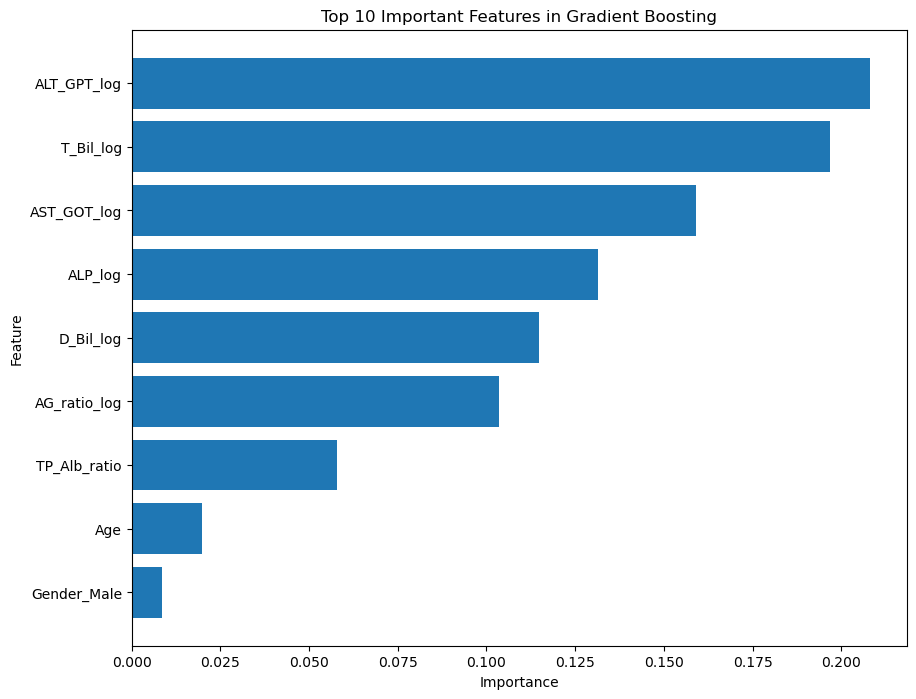

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['disease'])
y = train_data['disease']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

# GradientBoostingモデルの定義
gb_model = GradientBoostingClassifier(verbose=0, random_state=24)

# ハイパーパラメータの候補を設定
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]  # 'auto'を削除し、Noneを追加
}

# StratifiedKFoldを設定
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)

# 繰り返しStratifiedKFoldの設定
# kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=24)

# ランダムサーチの設定
gb_random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, 
                                      n_iter=20, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1, 
                                      random_state=24)

# トレーニングデータでランダムサーチを実行
gb_random_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {gb_random_search.best_params_}")
print(f"Best cross-validation AUC: {gb_random_search.best_score_:.4f}")

# 最適なモデルを取得
gb_best = gb_random_search.best_estimator_

# 最適なモデルで再トレーニング
gb_best.fit(X_train, y_train) 

# テストデータでの予測とAUC計算
y_pred_proba = gb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 重要度の取得と上位10の特徴量を可視化
importance = gb_best.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# 重要な特徴量のリストを表示
print("Model's most important features (Top 10):")
print(importance_df)

# 重要な特徴量を上位に表示するプロット
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features in Gradient Boosting')
plt.gca().invert_yaxis()  # 最も重要な特徴量を上に表示
plt.show()


## 相互作用の確認

In [2]:
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'T_Bil_log', 'ALT_GPT_log', 'AST_GOT_log',
    'ALP_log', 'D_Bil_log', 'AG_ratio_log', 
    'TP_Alb_ratio', 'Age', 'Gender_Male'
]

# VIFを計算
X = train_data[selected_features]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)


        feature       VIF
0     T_Bil_log  3.768357
1   ALT_GPT_log  2.047785
2   AST_GOT_log  2.180140
3       ALP_log  1.082671
4     D_Bil_log  3.537961
5  AG_ratio_log  1.820753
6  TP_Alb_ratio  1.686176
7           Age  1.012485
8   Gender_Male  1.009686


In [10]:
!pip install shap

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.3/459.3 kB 6.8 MB/s eta 0:00:00ta 0:00:01
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)


# 特徴量を選択しグリッドサーチでトレーニングする

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits
Best parameters found: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation AUC: 0.9460640
Cross-Validation AUC Scores: [0.95701754 0.96403509 0.94824561 0.96140351 0.95263158 0.92631579
 0.98157895 0.92017544 0.91281604 0.91717524]
Mean Cross-Validation AUC: 0.9441394790376114
Test AUC: 0.9459686450167974
過学習の兆候は見られません。


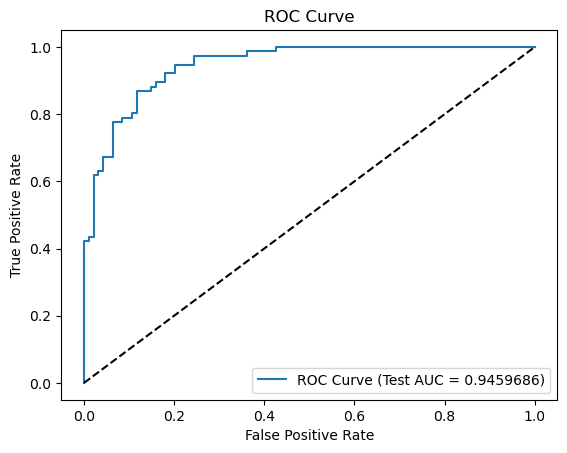

最適なGradient Boostingモデルが /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/gradient_boosting0921_1.joblib に保存されました。


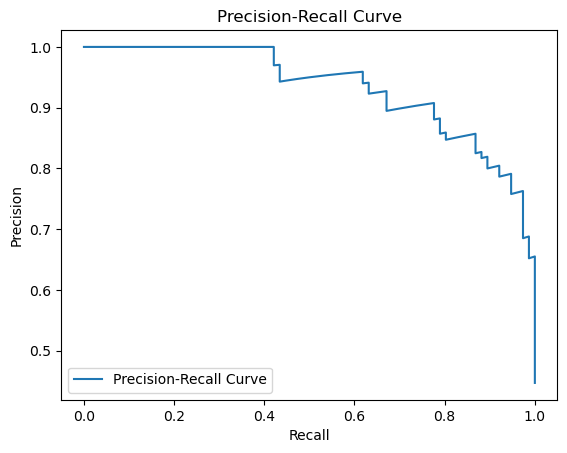

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import compute_sample_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'ALT_GPT_log', 'T_Bil_log', 'AST_GOT_log',
    'ALP_log', 'D_Bil_log', 'AG_ratio_log', 
    'TP_Alb_ratio', 'Age', 'Gender_Male'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['disease']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの範囲を設定
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.001, 0.01, 0.05],
    'max_depth': [3, 4],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],

}

# StratifiedShuffleSplitの設定
# sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=24)

# 繰り返しStratifiedKFoldの設定
# rkfd = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=24)

# StratifiedKFoldを設定
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# サンプルの重みを計算
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# Gradient Boostingモデルの定義
gb_model = GradientBoostingClassifier(random_state=123)

# グリッドサーチの設定
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                              cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行（サンプルの重みを適用）
gb_grid_search.fit(X_train, y_train, sample_weight=sample_weight)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {gb_grid_search.best_params_}")
print(f"Best cross-validation AUC: {gb_grid_search.best_score_:.7f}")

# 最適なモデルを取得
gb_best = gb_grid_search.best_estimator_

# 最適なモデルを使用して再トレーニング
gb_best.fit(X_train, y_train, sample_weight=sample_weight)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(gb_best, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = gb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model', 'gradient_boosting0921_1.joblib')
joblib.dump(gb_best, model_path)
print(f"最適なGradient Boostingモデルが {model_path} に保存されました。")

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


## 特徴量を選択し、ランダムサーチでトレーニングする

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
Best parameters found: {'subsample': 1.0, 'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.01}
Best cross-validation AUC: 0.9299027
Cross-Validation AUC Scores: [0.88055798 0.92850915 0.97017544 0.93684211 0.96666667 0.97719298
 0.88157895 0.90526316 0.93421053 0.93684211 0.92763731 0.92240628
 0.91666667 0.94736842 0.9245614  0.94824561 0.92631579 0.94824561
 0.92982456 0.93947368 0.87183958 0.94594595 0.93684211 0.98421053
 0.95350877 0.9122807  0.95263158 0.92105263 0.88508772 0.92192982
 0.91891892 0.92938099 0.88859649 0.91929825 0.91842105 0.95175439
 0.92192982 0.97192982 0.92192982 0.94385965 0.92850915 0.96512642
 0.90526316 0.91315789 0.91403509 0.93859649 0.92368421 0.95877193
 0.91578947 0.93684211]
Mean Cross-Validation AUC: 0.9303941785588647
Test AUC: 0.9766237402015677
過学習の兆候は見られません。


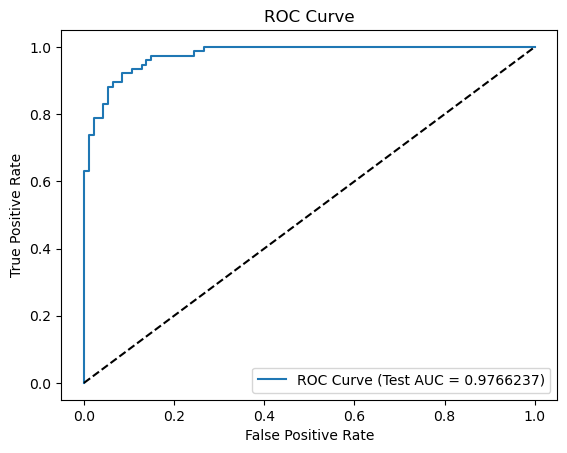

最適なGradient Boostingモデルが /Users/hayakawakazue/Downloads/signate/model/gradient_boosting0919_2.joblib に保存されました。


In [7]:
import pandas as pd
import numpy as np
from sklearn.utils import compute_sample_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt


# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_scaled_robust_0919_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'T_Bil_log', 'ALT_GPT_log', 'AST_GOT_log',
    'ALP_log', 'D_Bil_log', 'AG_ratio_log', 
    'TP_Alb_ratio', 'Age', 'Gender_Male'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['disease']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの範囲を設定
param_dist = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [2, 3],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [10, 20, 30]
}


# StratifiedKFoldを使用したクロスバリデーションの設定
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

# 繰り返しStratifiedKFoldの設定
rkfd = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=24)

# サンプルの重みを計算
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# Gradient Boostingモデルの定義
gb_model = GradientBoostingClassifier(random_state=24)

# ランダムサーチの設定
gb_random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, 
                                      n_iter=50, cv=rkfd, scoring='roc_auc', n_jobs=-1, random_state=24, verbose=1)

# ランダムサーチの実行（サンプルの重みを適用）
gb_random_search.fit(X_train, y_train, sample_weight=sample_weight)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {gb_random_search.best_params_}")
print(f"Best cross-validation AUC: {gb_random_search.best_score_:.7f}")

# 最適なモデルを取得
gb_best = gb_random_search.best_estimator_

# 最適なモデルを使用して再トレーニング
gb_best.fit(X_train, y_train, sample_weight=sample_weight)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(gb_best, X_train, y_train, cv=rkfd, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = gb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'gradient_boosting0919_2.joblib')
joblib.dump(gb_best, model_path)
print(f"最適なGradient Boostingモデルが {model_path} に保存されました。")


### 